# **Iris predict**

In [2]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import itertools
import io
import contextlib
import matplotlib

In [43]:
# Main function 
def predictIris(path, f=np.pi, save=False, output_width=256):
    """
    Rozszerzona funkcja przetwarzania zdjęcia tęczówki, która wykrywa granice źrenicy i tęczówki,
    następnie rozwija tęczówkę do prostokątnej postaci i wyznacza jej kod.
    Parametr f (częstotliwość) użytkownik podaje samodzielnie - przykładowo f = pi.
    """
    image_array = load_img(path)
    gray_image = convert_to_grayscale(image_array)
    
    print("############# BINARY IMAGE FOR PUPIL #############")
    binary_image_pupil = binarize_image(gray_image, X=4.5)   
    print("############# BINARY IMAGE FOR IRIS #############")
    binary_image_iris = binarize_image(gray_image, X=1.6)
    
    print("############# PUPIL EXTRACTED #############")
    (x_pupil, y_pupil, r_pupil) = clean_pupil(binary_image_pupil)
    print("############# IRIS EXTRACTED #############")
    r_iris = clean_iris(binary_image_iris)
      
    image_with_pupil = draw_circle(image_array, x_pupil, y_pupil, r_pupil)
    image_with_pupil_and_iris = draw_circle(image_with_pupil, x_pupil, y_pupil, r_iris)
    
    print("############# FOUND PUPIL AND IRIS #############")
    show_image(image_with_pupil_and_iris)
    
    if save:
        save_path = os.path.join("found", f'{os.path.basename(path)}_found.bmp')
        cv2.imwrite(save_path, image_with_pupil_and_iris)
        print(f"Image saved to {save_path}")
    
    print("############# UNWRAPPED IRIS #############")    
    unwrapped_iris = unwrap_iris(image_array, x_pupil, y_pupil, r_pupil, r_iris)
    show_image(unwrapped_iris)

    visualize_band_boundaries(unwrapped_iris)    

    bands = extract_central_bands(unwrapped_iris, output_width)
    visualize_bands(bands)

    print("############# COMPUTING IRIS CODE #############")
    iris_code = compute_full_iris_code(unwrapped_iris, f, num_bands=8, num_coeffs=128, output_width=output_width)
    print("Iris Code (binary):")
    print(iris_code)

    visualize_iris_code_by_band(iris_code, num_bands=8)
    
    return iris_code
    
   
# Show image    
def show_image(image_array):
    plt.figure(figsize=(4, 4))
    plt.imshow(image_array)
    plt.axis("off") 
    plt.show()
        
# Load image
def load_img(path):
    image = Image.open(path)
    image_array = np.array(image)
    #print("############# ORIGINAL EYE IMAGE #############")
    #show_image(image_array)
    return image_array
    
# Convert to grayscale
def convert_to_grayscale(image_array):
    gray_image = np.zeros((image_array.shape[0], image_array.shape[1]), dtype=np.uint8)
    gray_image = np.mean(image_array, axis=2)
    gray_image = np.array(gray_image, dtype=np.uint8)
    print("############# GRAY IMAGE #############")
    show_image(np.dstack((gray_image, gray_image, gray_image)))
    return gray_image

# Binarize with threshold
def binarize_image(image_array, X):
    P = np.mean(image_array)
    threshold = P / X
    binary_image = np.zeros_like(image_array)
    binary_image[image_array > threshold] = 255
    show_image(np.dstack((binary_image, binary_image, binary_image)))
    return binary_image

# Clean pupil image
def clean_pupil(binary_image):
    kernel = np.array([[1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],], dtype=np.uint8)
    kernel_small = np.ones((3, 3), np.uint8)   

    clean_image = binary_image.copy()
    
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel)
    clean_image = cv2.erode(clean_image, kernel, iterations=2)
    clean_image = cv2.dilate(clean_image, kernel_small, iterations=2)
    clean_image = cv2.medianBlur(clean_image, 5)
 
    clean_image = keep_largest_object(clean_image)
    clean_image = cv2.GaussianBlur(clean_image, (9, 9), 0)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel)
    horizontal_projection, vertical_projection = show_projections(clean_image, binary_image)
    return find_pupil(horizontal_projection, vertical_projection)

# Clean iris image
def clean_iris(binary_image):
    kernel_large = np.ones((10, 10), np.uint8)   
    kernel_medium = np.ones((5, 5), np.uint8)  
    kernel_small = np.ones((3, 3), np.uint8)  
    kernel_circle_small = np.array([[0, 1, 0],
                                 [1, 1, 1],
                                 [0, 1, 0]], dtype=np.uint8)
    clean_image = binary_image.copy() 

    clean_image = cv2.dilate(clean_image, kernel_medium, iterations=1)
    clean_image = keep_largest_object(clean_image)
    clean_image = cv2.erode(clean_image, kernel_small, iterations=5)
    clean_image = cv2.dilate(clean_image, kernel_medium, iterations=5)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel_large)
    clean_image = cv2.dilate(clean_image, kernel_large, iterations=1)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel_large)
    clean_image = cv2.erode(clean_image, kernel_small, iterations=10)
    clean_image = cv2.blur(clean_image, (5, 5), 0)
    clean_image = keep_largest_object(clean_image)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel_large)
    clean_image = cv2.GaussianBlur(clean_image, (9, 9), 0)
    horizontal_projection, vertical_projection = show_projections(clean_image, binary_image)   
    return find_iris(horizontal_projection, vertical_projection) 

def keep_largest_object(binary_image):
    # Odwracamy kolory: obiekt (0) -> (255), tło (255) -> (0)
    inverted_image = cv2.bitwise_not(binary_image)

    # Znajdujemy składowe połączone
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(inverted_image, connectivity=8)

    if num_labels == 1:
        # Nie znaleziono żadnych obiektów
        return binary_image
    
    # Szukamy największego obiektu (pomijamy indeks 0, bo to tło)
    largest_label = 1 + np.argmax(stats[1:, 4])

    # Tworzymy nowy obraz binarny, gdzie zostaje tylko największy obiekt
    largest_object = np.zeros_like(binary_image, dtype=np.uint8)
    largest_object[labels == largest_label] = 255  # Ustawiamy największy obiekt na biały

    # Odwracamy kolory z powrotem: obiekt (255) -> (0), tło (0) -> (255)
    return cv2.bitwise_not(largest_object)

# Show projections
def show_projections(clean_image, binary_image):
    horizontal_projection = np.sum(clean_image, axis=1)  
    vertical_projection = np.sum(clean_image, axis=0)   
    height, width = clean_image.shape
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    axs[0, 0].imshow(np.dstack((clean_image, clean_image, clean_image)))
    axs[0, 0].set_title("Binary Image after Morphology")
    axs[0, 0].axis("off")
    axs[1, 1].axis("off")
    rect = patches.Rectangle((0, 0), width, height, linewidth=3, edgecolor='black', facecolor='none')
    axs[0, 0].add_patch(rect)
    axs[0, 1].plot(horizontal_projection, range(height), color='blue', linewidth=2)
    axs[0, 1].set_title("Horizontal Projection")
    axs[0, 1].set_ylim(height, 0)  
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)
    axs[1, 0].plot(range(width), vertical_projection, color='red', linewidth=2)
    axs[1, 0].set_title("Vertical Projection")
    axs[1, 0].set_xlim(0, width)  
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)
    axs[1, 1].imshow(np.dstack((binary_image, binary_image, binary_image)))
    axs[1, 1].set_title("Binary Image")
    rect2 = patches.Rectangle((0, 0), width, height, linewidth=3, edgecolor='black', facecolor='none')
    axs[1, 1].add_patch(rect2)
    plt.tight_layout()
    plt.show()
    return horizontal_projection, vertical_projection

# Find pupil
def find_pupil(horizontal_projection, vertical_projection):
    y_pupil = int(np.median(np.where(horizontal_projection == np.min(horizontal_projection))[0]))
    x_pupil = int(np.median(np.where(vertical_projection == np.min(vertical_projection))[0]))

    horizontal_diff = np.abs(np.diff(np.array(horizontal_projection, dtype=np.int64)))
    vertical_diff = np.abs(np.diff(np.array(vertical_projection, dtype=np.int64)))
    
    pupil_edges_y = np.where(horizontal_diff > np.max(horizontal_diff) * 0.3)[0]
    pupil_edges_x = np.where(vertical_diff > np.max(vertical_diff) * 0.3)[0]
    if len(pupil_edges_y) > 1:
        r_pupil_y = (pupil_edges_y[-1] - pupil_edges_y[0]) // 2
    else:
        r_pupil_y = 0
    if len(pupil_edges_x) > 1:
        r_pupil_x = (pupil_edges_x[-1] - pupil_edges_x[0]) // 2
    else:
        r_pupil_x = 0 
    r_pupil = (r_pupil_x + r_pupil_y) // 2
    return (x_pupil, y_pupil, r_pupil)

# Find iris
def find_iris(horizontal_projection, vertical_projection):
    horizontal_diff = np.abs(np.diff(np.array(horizontal_projection, dtype=np.int64)))
    vertical_diff = np.abs(np.diff(np.array(vertical_projection, dtype=np.int64)))

    iris_edges_y = np.where(horizontal_diff > np.max(horizontal_diff) * 0.4)[0]
    iris_edges_x = np.where(vertical_diff > np.max(vertical_diff) * 0.4)[0]

    if len(iris_edges_y) > 1:
        r_iris_y = (iris_edges_y[-1] - iris_edges_y[0]) // 2
    else:
        r_iris_y = 0

    if len(iris_edges_x) > 1:
        r_iris_x = (iris_edges_x[-1] - iris_edges_x[0]) // 2
    else:
        r_iris_x = 0 

    r_iris = (3 * r_iris_x + r_iris_y) // 4

    return r_iris

# Draw found iris and pupil
def draw_circle(image_array, x, y, r):
    image_with_circle = image_array.copy()
    image_with_circle = cv2.circle(image_with_circle, (x, y), r, (255, 0, 0), 1)
    return image_with_circle

def unwrap_iris(image, x_pupil, y_pupil, r_pupil, r_iris, output_shape=(64, 360), angle_offset=270):
    """
    Rozwija wykrytą tęczówkę do prostokątnej postaci zgodnie z opisem pseudobiegunowego układu współrzędnych.
    Użyto radialnego przekształcenia liniowego: r_norm ∈ [0, 1]
    """
    height, width = output_shape
    offset_rad = np.deg2rad(angle_offset)
    theta = np.linspace(0, 2 * np.pi, width, endpoint=False) + offset_rad  
    r_norm = np.linspace(0, 1, height)  # [0 - źrenica], [1 - zewn. kontur]

    r_grid, theta_grid = np.meshgrid(r_norm, theta, indexing='ij')
    r_actual = r_pupil + r_grid * (r_iris - r_pupil)
    x_grid = (x_pupil + r_actual * np.cos(theta_grid)).astype(int)
    y_grid = (y_pupil + r_actual * np.sin(theta_grid)).astype(int)

    x_grid = np.clip(x_grid, 0, image.shape[1] - 1)
    y_grid = np.clip(y_grid, 0, image.shape[0] - 1)

    unwrapped_iris = image[y_grid, x_grid]
    return unwrapped_iris



def compute_1d_representation(band):
    """
    Dla danego pasa tęczówki funkcja oblicza jednowymiarowy sygnał poprzez uśrednienie wierszy 
    przy użyciu okna Gaussowskiego.
    
    Dzięki temu waga przypisana każdemu wierszowi maleje wraz z oddaleniem od środka obrazu,
    a wynikowy sygnał 1D (dla każdej kolumny) reprezentuje dobrze centralny fragment pasa tęczówki.
    """
    h, _, _ = band.shape
    # Konwersja do skali szarości – średnia z kanałów (np. R, G, B)
    band_gray = band.mean(axis=2)  # wynik: macierz h x w
    
    # Parametry okna Gaussowskiego – wybieramy środek jako h/2 i ustalamy sigma (np. h/8)
    center = h / 2.0
    sigma = h / 8.0 # można dostroić tę wartość w zależności od obrazu
    
    # Tworzymy wektor wag dla każdego wiersza
    y = np.arange(h)
    weights = np.exp(-((y - center) ** 2) / (2 * sigma ** 2))
    weights = weights / np.sum(weights)  # normalizacja, aby suma wag wynosiła 1
    
    # Uśredniamy wiersze, mnożąc każdą kolumnę przez odpowiadającą wagę
    # weights[:, np.newaxis] powoduje, że wektor wag jest broadcastowany do kształtu (h, 1)
    signal = np.sum(band_gray * weights[:, np.newaxis], axis=0)
    
    return signal

# Funkcja wyznaczająca 1-wymiarowe współczynniki Gabor dla sygnału
def compute_gabor_coefficients(signal, f, num_coeffs=128):
    """
    Dla jednowymiarowego sygnału I(x) wyznacza współczynniki rozwinięcia Gaborowych.
    Przyjmujemy:
      c_k = sum_{i=0}^{L-1} I[i] * exp(-((i - x_k)^2)/(sigma^2)) * exp(-i2π f i)
    gdzie sigma = 1/2 π f, a x_k to centra falek wybrane równomiernie (num_coeffs elementów).
    """
    L = len(signal)
    centers = np.linspace(0, L - 1, num_coeffs)
    sigma = 1/2 * np.pi * f
    coeffs = []
    indices = np.arange(L)
    for x0 in centers:
        # Okno Gaussowskie o środku x0
        gaussian_window = np.exp(-((indices - x0) ** 2) / (sigma ** 2))
        # Modulacja zespolona
        modulation = np.exp(-1j * 2 * np.pi * f * (indices - x0)) 
        c = np.sum(signal * gaussian_window * modulation)
        coeffs.append(c)
    return np.array(coeffs)

# Funkcja kodująca pojedynczy współczynnik na podstawie fazy (argumentu)
def encode_coefficient(c):
    """
    Koduje współczynnik c (liczbę zespoloną) do 2-bitowego ciągu według fazy:
      - Faza w [0, π/2)   -> "00"
      - Faza w [π/2, π]   -> "01"
      - Faza w (-π, -π/2] -> "11"
      - Faza w (-π/2, 0)  -> "10"
    """
    angle = np.angle(c)  # zakres (-π, π]
    if 0 <= angle < np.pi / 2:
        return "00"
    elif np.pi / 2 <= angle <= np.pi:
        return "01"
    elif -np.pi <= angle <= -np.pi / 2:
        return "11"
    elif -np.pi / 2 < angle < 0:
        return "10"
    else:
        return "00"  # zabezpieczenie

# Funkcja obliczająca kod dla jednego pasa tęczówki
def compute_band_iris_code(band, f, num_coeffs=128):
    """
    Dla pojedynczego pasa (2D) tęczówki:
      1. Obliczamy jednowymiarową reprezentację (uśrednianie kolumnowe z oknem Gaussowskim).
      2. Wyznaczamy num_coeffs współczynników Gabor przy użyciu stałej częstotliwości f.
      3. Każdy współczynnik kodujemy na 2-bitowy ciąg.
    Zwracany wynik to ciąg bitowy o długości 2*num_coeffs.
    """
    signal = compute_1d_representation(band)
    coeffs = compute_gabor_coefficients(signal, f, num_coeffs)
    band_code = "".join(encode_coefficient(c) for c in coeffs)
    return band_code

# Funkcja składająca kod z całej tęczówki (dzielonej na num_bands pasów)
def compute_full_iris_code(unwrapped_iris, f, num_bands=8, num_coeffs=128, output_width=256):
    """
    Cały kod tęczówki obliczamy w następujący sposób:
      1. Z rozwiniętego obrazu tęczówki wyodrębniamy 8 centralnych pasów,
         o stałej szerokości (output_width), aby zapewnić spójność.
      2. Dla każdego pasu wyznaczamy 2-bitowy kod (przy użyciu transformacji Gabora).
      3. Łączymy wyniki dla poszczególnych pasów.
    Zwracany ciąg bitów ma długość num_bands * (2 * num_coeffs).
    """
    bands = extract_central_bands(unwrapped_iris, output_width)
    full_code = ""
    for band in bands:
        band_code = compute_band_iris_code(band, f, num_coeffs)
        full_code += band_code
    return full_code


def visualize_iris_code_by_band(iris_code: str, num_bands: int = 8):
    """
    Wizualizuje kod tęczówki w postaci obrazu czarno-białego, gdzie:
      - każdy z 8 wierszy odpowiada jednemu pasowi,
      - kolumny to kolejne bity danego pasa.
    
    Parametry:
      iris_code  - ciąg bitów (np. "010101...") stanowiący kod tęczówki
      num_bands  - liczba pasów (domyślnie 8)
    """
    total_bits = len(iris_code)
    if total_bits % num_bands != 0:
        raise ValueError("Długość kodu nie jest podzielna przez liczbę pasów.")
    
    bits_per_band = total_bits // num_bands
    # Tworzymy tablicę o wymiarach (8 wierszy, bits_per_band kolumn)
    arr = np.zeros((num_bands, bits_per_band), dtype=np.uint8)
    
    # Wypełniamy każdy wiersz (pas) odpowiednim fragmentem bitów
    for band_index in range(num_bands):
        start = band_index * bits_per_band
        stop = (band_index + 1) * bits_per_band
        segment = iris_code[start:stop]
        
        # '1' → 1 (czarny), '0' → 0 (biały)
        for i, bit in enumerate(segment):
            arr[band_index, i] = 1 if bit == '1' else 0

    # Wyświetlamy całość
    plt.figure(figsize=(bits_per_band/16, num_bands/3))
    # vmin=0, vmax=1 -> 0=biały, 1=czarny (w cmap='gray' czarny będzie 1)
    plt.imshow(arr, cmap='gray', vmin=0, vmax=1, aspect='auto')
    plt.axis('off')  # usuwamy osie dla czytelnego efektu
    plt.show()


def extract_central_bands(unwrapped_iris, output_width: int, vertical_crop_ratio: float = 1.0):
    """Wyodrębnia 8 współśrodkowych wycinków pierścienia tęczówki.

    • Najpierw zachowuje centralny fragment (vertical_crop_ratio).
    • Pierścień dzielony jest na 8 równych pasów radialnych.
    • Dla każdego pasa stosuje się azymutalny wycinek:
        - Pasy 0-3 → 330° (pełny okrąg bez 30° sektora poniżej źrenicy).
        - Pasy 4-5 → 226° (symetryczne względem osi pionowej).
        - Pasy 6-7 → 180° (lewe + prawe półkole).
    Zakładamy unwrap wykonany z angle_offset=270°, więc kolumna 0 odpowiada kątowi 270° (dół)."""

    # Ustal wymiar obrazu
    if unwrapped_iris.ndim == 3:
        H, W, _ = unwrapped_iris.shape
    else:
        H, W = unwrapped_iris.shape

    # pionowe przycięcie (powieki)
    top = int((1 - vertical_crop_ratio) / 2 * H)
    bottom = H - top
    roi = unwrapped_iris[top:bottom]
    Hc = roi.shape[0]
    band_h = Hc // 8

    # Azymutalne zakresy
    spans = [330, 330, 330, 330, 226, 226, 180, 180]  # w stopniach
    center_x = W // 2
    bands = []
    for i in range(8):
        band = roi[i * band_h : (i + 1) * band_h]
        span = spans[i]
        crop_w = int(round(span / 360 * W))
        x0 = center_x - crop_w // 2
        x1 = x0 + crop_w
        band_cropped = band[:, x0:x1]
        # reskalowanie azymutalne do output_width
        band_resized = cv2.resize(band_cropped, (output_width, band_cropped.shape[0]), interpolation=cv2.INTER_LINEAR)
        bands.append(band_resized)
    return bands

def visualize_bands(bands):
    """
    Skleja 8 poziomych pasów (obrazów) pionowo i wyświetla wynik.
    Każdy pas odpowiada poziomemu wycinkowi rozwiniętej tęczówki.
    """
    # Upewnij się, że wszystkie pasy mają tę samą wysokość
    min_height = min(band.shape[0] for band in bands)
    bands_equal = [band[:min_height, :] for band in bands]
    
    # Sklejamy pasy pionowo
    stacked = np.vstack(bands_equal)
    
    # Zwiększamy rozmiar wykresu – podwajamy poprzedni rozmiar
    plt.figure(figsize=(stacked.shape[1] / 50, stacked.shape[0] / 50))
    plt.imshow(stacked, cmap='gray', aspect='auto')
    plt.title("Wyodrębnione poziome pasy tęczówki")
    plt.axis('off')
    plt.show()

def rotate_iris_code(code: str, bits_per_rotation: int) -> list:
    """
    Tworzy listę obrotów kodu o zadany krok (bits_per_rotation).
    Umożliwia dopasowanie kodów niezależnie od obrotu tęczówki.
    """
    rotated_codes = []
    for shift in range(0, len(code), bits_per_rotation):
        rotated = code[shift:] + code[:shift]
        rotated_codes.append(rotated)
    return rotated_codes


def visualize_band_boundaries(unwrapped_iris, vertical_crop_ratio=1):
    """
    Na obrazie rozwiniętej tęczówki (unwrapped iris) nakłada oznaczenia pokazujące:
      1. Pionowe granice centralnego regionu (wycięcie górnej i dolnej części, np. powiek).
      2. Poziomy podział centralnego regionu na 8 równych pasów.
      3. W obrębie każdego pasa – pionowe granice poziomego wycinka, 
         odpowiadającego zakresowi kątowemu (różne dla pasów 1-4, 5-6 i 7-8).
         
    Parametry:
       unwrapped_iris      - obraz rozwiniętej tęczówki (np. grayscale lub kolorowy),
                             którego pełna szerokość odpowiada 360°.
       vertical_crop_ratio - stosunek wysokości centralnego regionu do całej wysokości obrazu.
    """
    h, w = unwrapped_iris.shape[:2]
    
    # Wyznaczamy pionowe przycięcie: zachowujemy centralny fragment, aby ominąć artefakty powiek.
    crop_top = int((1.0 - vertical_crop_ratio) / 2 * h)
    crop_bottom = h - crop_top
    central_region = unwrapped_iris[crop_top:crop_bottom, :]
    new_h, new_w = central_region.shape[:2]  # new_w powinno być równe w
    
    # Podział centralnego regionu na 8 równych poziomych pasów
    num_bands = 8
    band_height = new_h / num_bands
    
    # Przygotowujemy wykres z oryginalnym obrazem (pełny unwrapped iris)
    plt.figure(figsize=(w/50, h/50))
    plt.imshow(unwrapped_iris, cmap='gray', aspect='auto')
    
    # Rysujemy pionowe linie pokazujące, że zachowany został tylko centralny region
    plt.axhline(y=crop_top, color='cyan', linestyle='-', linewidth=2, label='Centralny region')
    plt.axhline(y=crop_bottom, color='cyan', linestyle='-', linewidth=2)
    
    # Rysujemy poziomy podział centralnego regionu na 8 równych pasów
    for i in range(1, num_bands):
        y_line = crop_top + i * band_height
        plt.axhline(y=y_line, color='red', linestyle='--', linewidth=2)
    
    # Dla każdego pasu wyznaczamy poziomy wycinek (czerwony fragment) – granice, które zostały zachowane:
    # Zgodnie z algorytmem, dla danego pasa:
    #  - Jeśli i < 4: angular_span = 330°
    #  - Jeśli 4 <= i < 6: angular_span = 226°
    #  - Jeśli i >= 6: angular_span = 180°
    # Cała szerokość centralnego regionu odpowiada 360°.
    center_x = new_w // 2
    for i in range(num_bands):
        # Obliczenie pionowych granic pasu (w globalnych współrzędnych obrazu)
        y0 = crop_top + i * band_height
        y1 = y0 + band_height
        
        if i  >= 4:
            angular_span = 330.0
        elif i  >= 2:
            angular_span = 226.0
        else:
            angular_span = 180.0
        
        # Obliczamy szerokość wycinka w pikselach, przyjmując, że 360° odpowiada new_w pikseli
        crop_width = int(round(angular_span / 360.0 * new_w))
        x0 = center_x - crop_width // 2
        x1 = x0 + crop_width
        
        # Aby narysować te granice na oryginalnym obrazie, musimy uwzględnić, że central_region
        # zaczyna się na crop_top – więc współrzędne poziome są takie same, ale pionowe przesunięte.
        plt.axvline(x=x0, ymin=(y0/h), ymax=(y1/h), color='yellow', linestyle='-.', linewidth=2)
        plt.axvline(x=x1, ymin=(y0/h), ymax=(y1/h), color='yellow', linestyle='-.', linewidth=2)
    
    plt.title("Granice centralnego regionu i wyciętych fragmentów pasów tęczówki")
    plt.axis('off')
    plt.show()

def hamming_distance_np(code1: str, code2: str) -> float:
    """
    Ta wersja najpierw konwertuje ciągi na tablice liczb całkowitych, a potem oblicza odległość.
    """
    if len(code1) != len(code2):
        raise ValueError("Kody muszą mieć tę samą długość")
    
    arr1 = np.array([int(b) for b in code1])
    arr2 = np.array([int(b) for b in code2])
    diff = np.sum(arr1 != arr2)
    return diff / len(code1)



def compare_within_person(person_id, eye, f_value, verbose=False, plot_histogram=True):
    with silent_mode(active=not verbose):
        codes = {}
        for n in range(1, 6):
            path = f"data/eye_p{person_id:02d}_{eye}{n}.bmp"
            codes[n] = predictIris(path, f=f_value)

        distances = [
            min(hamming_distance_np(c1, r)
                for r in rotate_iris_code(c2, 32))
            for (_, c1), (_, c2) in itertools.combinations(codes.items(), 2)
        ]
    
    if plot_histogram:
        plt.figure(figsize=(8, 6))
        plt.hist(distances, bins=10, edgecolor='black')
        plt.title(f"Hamming distances between images of person {person_id}")
        plt.xlabel("Hamming distance"); plt.ylabel("Count"); plt.grid(alpha=.6)
        plt.show()

    return distances

def compare_within_persons_range(person_ids, eye, f_value, verbose=False, skip_ids=None):
    """
    Dla każdej osoby w person_ids (z pominięciem skip_ids) wywołuje compare_within_person z wykresem wyłączonym,
    zbiera wszystkie odległości i rysuje łączny histogram.
    """
    # Filtrujemy listę, pomijając wskazane ID
    if skip_ids is None:
        skip_ids = []
    filtered_ids = [pid for pid in person_ids if pid not in skip_ids]

    all_distances = []
    for pid in filtered_ids:
        if verbose:
            print(f"Processing person {pid}")
        d = compare_within_person(pid, eye, f_value, verbose=verbose, plot_histogram=False)
        all_distances.extend(d)

    plt.figure(figsize=(10, 6))
    plt.hist(all_distances, bins=30, edgecolor='black')
    plt.title(f"Intra-person Hamming distances (persons {filtered_ids[0]}–{filtered_ids[-1]})")
    plt.xlabel("Hamming Distance")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    return all_distances


# --------------------------------------------------------------

def compare_people_multiple(person_ids, eye, f_value, verbose=False, plot_histogram=True):
    """
    Porównuje kody między wszystkimi parami różnych osób w person_ids.
    Zwraca listę odległości Hamminga (minimalne po rotacjach) i opcjonalnie histogram.
    """
    # załaduj kody każdej osoby
    with silent_mode(active=not verbose):
        iris_codes = {}
        for pid in person_ids:
            if verbose: print(f"Loading person {pid}")
            codes = [predictIris(f"data/eye_p{pid:02d}_{eye}{n}.bmp", f=f_value) for n in range(1,6)]
            iris_codes[pid] = codes

        # porównaj wszystkie unikalne pary osób
        distances = []
        for p1, p2 in itertools.combinations(person_ids, 2):
            if verbose: print(f"Comparing {p1} vs {p2}")
            for c1 in iris_codes[p1]:
                for c2 in iris_codes[p2]:
                    distances.append(min(
                        hamming_distance_np(c1, r)
                        for r in rotate_iris_code(c2, 32)
                    ))

    if plot_histogram:
        plt.figure(figsize=(10,6))
        plt.hist(distances, bins=30, edgecolor='black')
        plt.title(f"Cross-person Hamming distances for {person_ids}")
        plt.xlabel("Hamming Distance"); plt.ylabel("Count"); plt.grid(alpha=0.5)
        plt.show()

    return distances



@contextlib.contextmanager
def silent_mode(active: bool = True, close_figs: bool = True):
    """
    • Jeśli active == True - tłumi wszystkie printy *i* blokuje wyświetlanie wykresów.
    • Jeśli active == False - niczego nie zmienia.
    """
    if not active:
        yield
        return

    # 1. przechwytuj stdout / stderr
    null_out = io.StringIO()
    cm_stdout = contextlib.redirect_stdout(null_out)
    cm_stderr = contextlib.redirect_stderr(null_out)

    # 2. zmień backend na 'Agg' (bez okienek) i podmień plt.show
    old_backend = matplotlib.get_backend()
    old_show = plt.show
    matplotlib.use('Agg', force=True)
    plt.show = lambda *a, **kw: None

    try:
        with cm_stdout, cm_stderr:
            yield
    finally:
        # przywracamy wszystko do stanu wyjściowego
        plt.show = old_show
        matplotlib.use(old_backend, force=True)
        if close_figs:
            plt.close('all')

## Simple example

In [ ]:
for file in os.listdir("data"):
    if file.endswith(".bmp"):
        file_path = os.path.join("data", file)
        print(f"Processed {file_path}")
        predictIris(file_path, save=True)


############# GRAY IMAGE #############


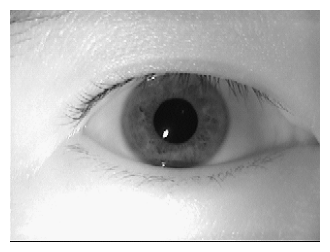

############# BINARY IMAGE FOR PUPIL #############


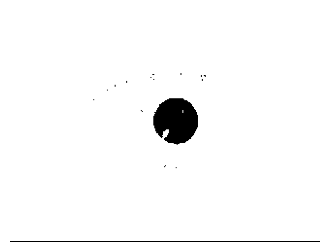

############# BINARY IMAGE FOR IRIS #############


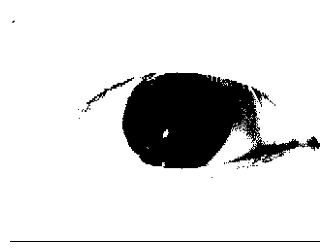

############# PUPIL EXTRACTED #############


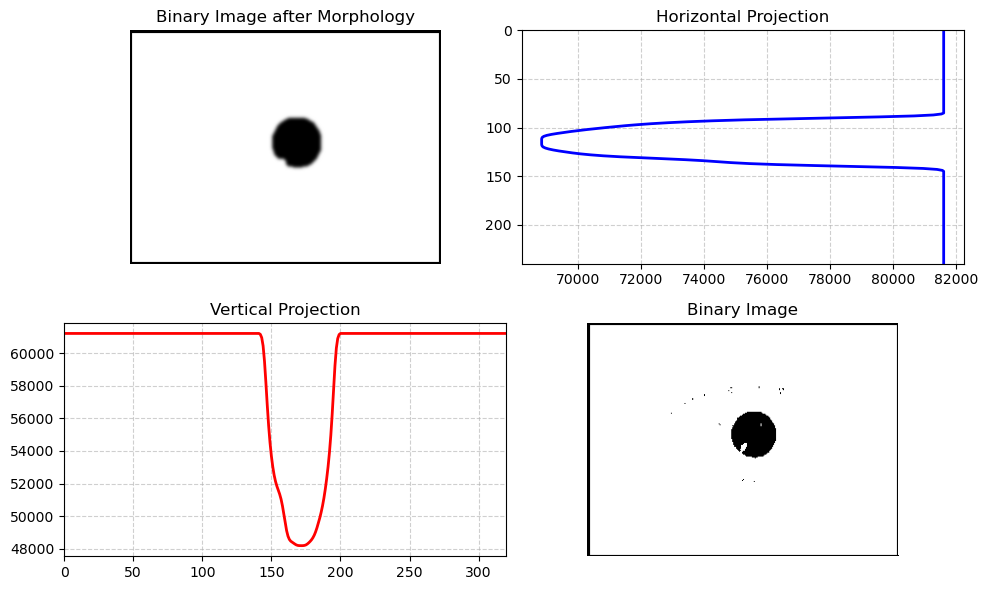

############# IRIS EXTRACTED #############


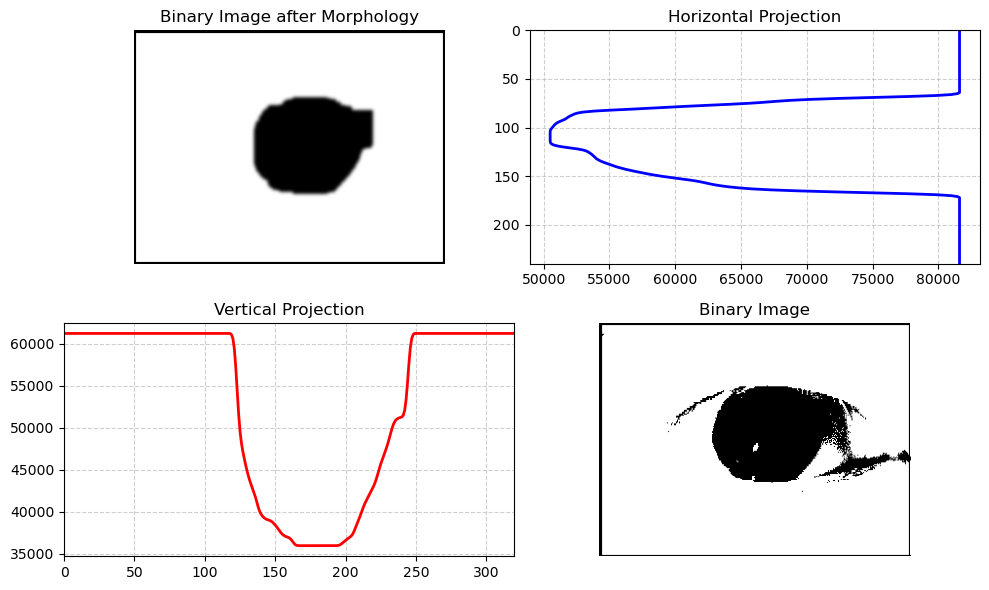

############# FOUND PUPIL AND IRIS #############


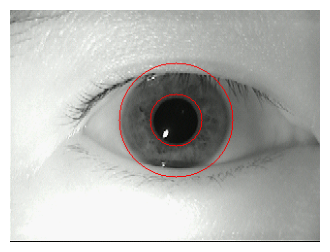

############# UNWRAPPED IRIS #############


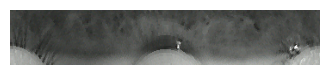

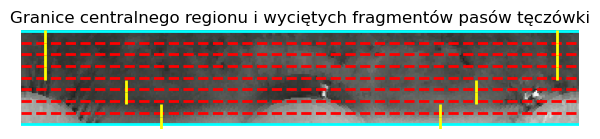

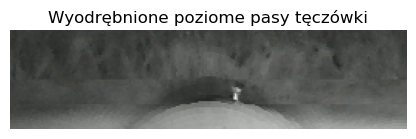

############# COMPUTING IRIS CODE #############
Iris Code (binary):
10000110001110000001100001110001011100010001111110111111100001111010100001111010000110001110000110001100011000011001110001110001111110010111100001111001111011101010001110000110000001110000000111000101110001110001111001100111100011111111101110001110011110001000010101111000000111000101110001110001010111100111111010000111100001111000111000011110100001100001111000000101110001111001111100011100111110011110000110111110000111100000001110000000011000000111100001111110100001111001111110011111111000011000111000111000100001011110011000111000011110011110000101111100110001111010011110100001111000100001111000010001100001111000011001111001111001010111100001111011101001111000111000111000001000010000111000010101100000011100011110000111111001111110100011101000111011100011100010000100000101100000011110000111011101110001111000011111111000111110001110111010000110000110000110000001111001110101100001011101110111111001111111100111100011101110

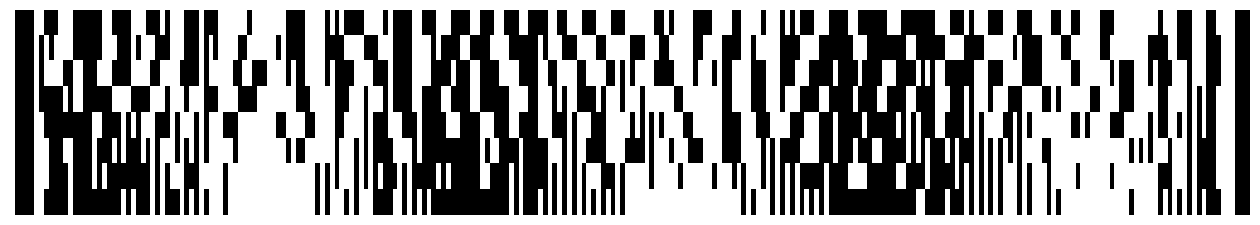

In [55]:
person_id = 42
eye = 'right'
photo_number = 1
path = os.path.join(f'data/eye_p{person_id:02d}_{eye}{photo_number}.bmp')

irisCode = predictIris(path, np.pi)

### Comparison of iris codes of different people using Hamming distance

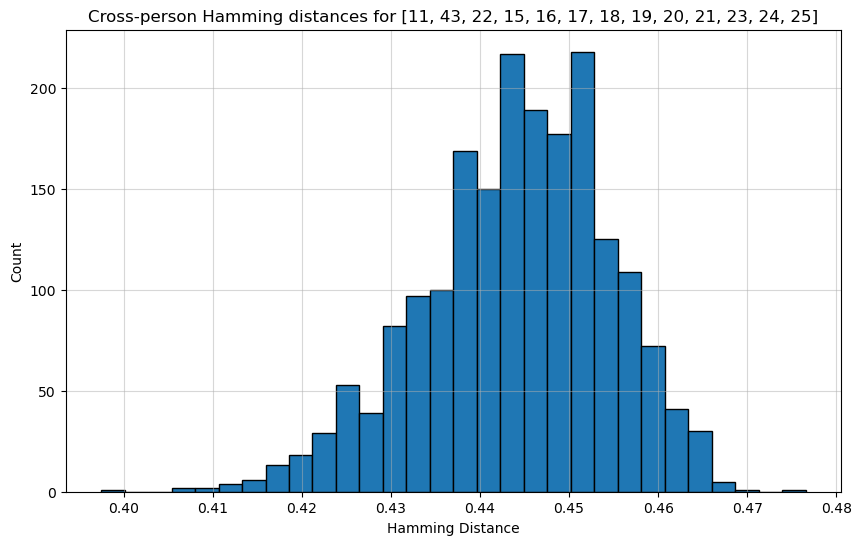

In [50]:
distances = compare_people_multiple(
    person_ids=[11,43, 22, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25],
    eye="left",
    f_value=np.pi + 0.2,
    verbose=False
)

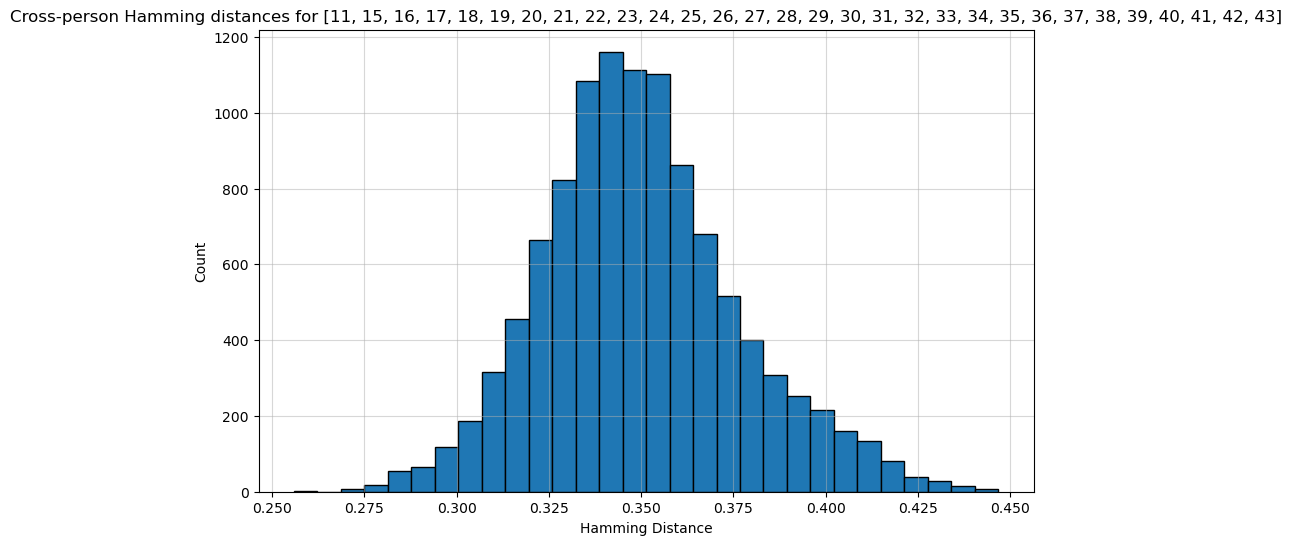

In [49]:
distances = compare_people_multiple(
    person_ids=[11, 15, 16, 17, 18, 19, 20, 21,22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
    eye="right",
    f_value=np.pi,
    verbose=False
)

In [ ]:
distances = compare_people_multiple(
    person_ids=[11,43],
    eye="left",
    f_value=np.pi,
    verbose=False
)

### Comparison of iris codes of the same person using Hamming distance

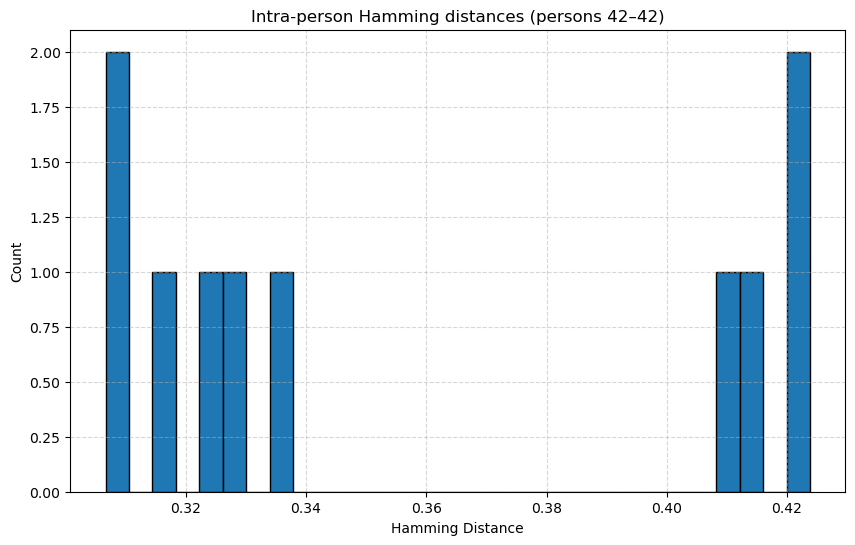

In [53]:
all_dist = compare_within_persons_range(
    person_ids= [42],
    eye="left",
    f_value=np.pi + 0.01,
    verbose=False
)

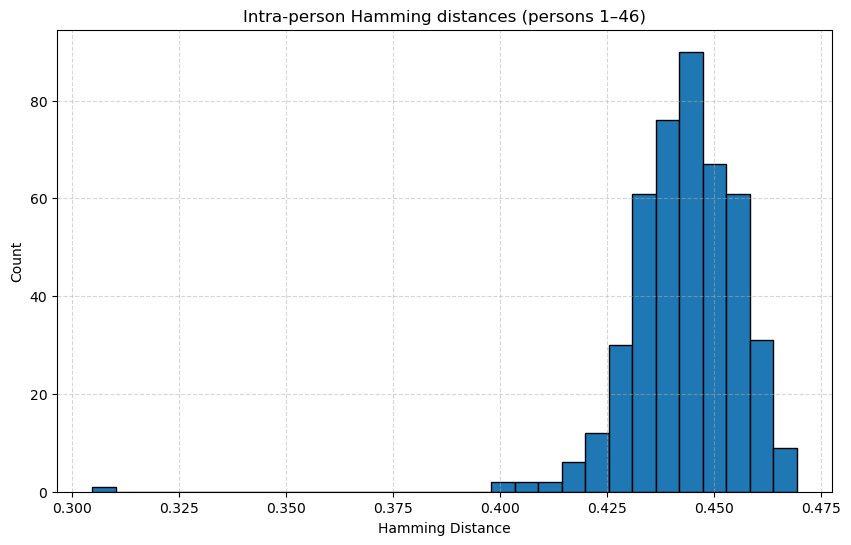

In [49]:
left_dists = compare_within_persons_range(
    person_ids=list(range(1, 47)),
    eye="left",
    f_value=np.pi + 0.2,
    verbose=False,
    skip_ids=[4]
)

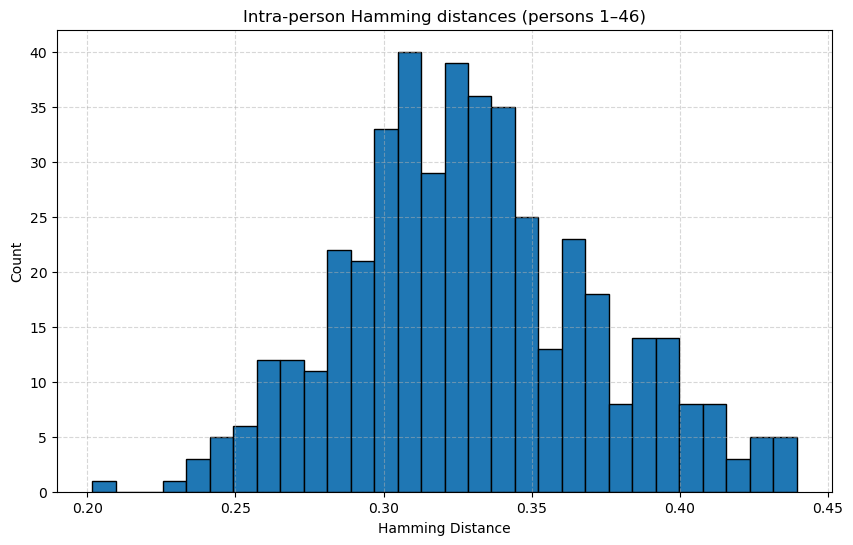

In [41]:
right_dists = compare_within_persons_range(
    person_ids=list(range(1, 47)),
    eye="right",
    f_value=np.pi,
    verbose=False,
    skip_ids=[4]
)

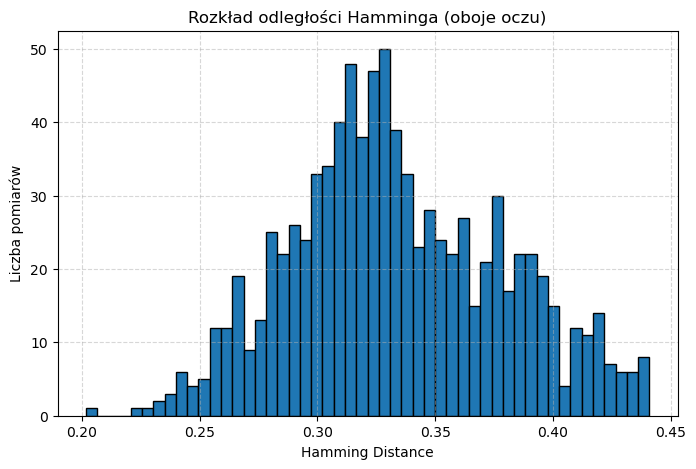

In [42]:
all_dists = np.concatenate([left_dists, right_dists])

# Narysuj histogram
plt.figure(figsize=(8,5))
plt.hist(all_dists, bins=50, edgecolor='black')
plt.title("Rozkład odległości Hamminga (oboje oczu)")
plt.xlabel("Hamming Distance")
plt.ylabel("Liczba pomiarów")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()